[View this notebook in nbviewer](https://nbviewer.jupyter.org/github/esowc/UNSEEN-open/blob/master/Initial_data_download.ipynb)  for better rendering

## Initial data download 
In this notebook, I will start playing around with the data download from the Climate Data Store (CDS). 

I follow the set-up from the [ml-flood project](https://nbviewer.jupyter.org/github/esowc/ml_flood/blob/master/notebooks/1_data_download_analysis_visualization/1.01_cdsapi_setup.ipynb):

You have to register at https://cds.climate.copernicus.eu/ and copy your UID and API key from https://cds.climate.copernicus.eu/user in the  `~/.cdsapirc`  file in the home directory of your user. See the [ml-flood project](https://nbviewer.jupyter.org/github/esowc/ml_flood/blob/master/notebooks/1_data_download_analysis_visualization/1.01_cdsapi_setup.ipynb) for more details.

In [4]:
UID = 'UID'
API_key = 'API key'

In [5]:
import os 
with open(os.path.join(os.path.expanduser('~'), '.cdsapirc'), 'w') as f:
    f.write('url: https://cds.climate.copernicus.eu/api/v2\n')
    f.write(f'key: {UID}:{API_key}')

In [6]:
pwd ## check the current working directory, which should be the UNSEEN-open directory

'/lustre/soge1/projects/ls/personal/timo/UNSEEN-open'

In [30]:
##This is so variables get printed within jupyter
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all"

## Our first request

We want to downlaod the monthly precipitation for february. I use the automatically generated request from the CDS server. There are two datasets we can use to download the data: [Seasonal forecast daily data on single levels](https://cds.climate.copernicus.eu/cdsapp#!/dataset/seasonal-original-single-levels?tab=form) and [Seasonal forecast monthly statistics on single levels](https://cds.climate.copernicus.eu/cdsapp#!/dataset/seasonal-monthly-single-levels?tab=form). We will use the latter for easy downloading of the monthly values. If we want to go to higher resolution, such as daily extremes, we will have to consult the other dataset. 

In our request, we will use the monthly mean. Interestingly, there is also the option to use the monthly maximum! We previously downloaded the data on daily resolution and extracted the monthly (or seasonal) maximum from that data. If we could just download the monthly maximum instead that might save a lot of processing power! However, you would be restricted to daily extremes only, for multi-day extremes (5 days is often used), you would have to do the original processing workflow.


We select the UK domain to reduce the size of the download.

In [15]:
##import packages
import cdsapi
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy
import cartopy.crs as ccrs

2020-04-14 10:25:55,458 INFO generated new fontManager


In [28]:
##Our first download:

c = cdsapi.Client()

c.retrieve(
    'seasonal-monthly-single-levels',
    {
        'format': 'netcdf',
        'originating_centre': 'ecmwf',
        'system': '5',
        'variable': 'total_precipitation',
        'product_type': [
            'monthly_mean', #'monthly_maximum',, 'monthly_standard_deviation',  
        ],
        'year': '1993', #data before 1993 is available.  
        'month': '01', #Initialization month. Target month is February (2), initialization months are August-January (8-12,1)
        'leadtime_month': [ ##Use of single months is much faster
            '1', '2',
        ],
        'area': [##Select UK domain to reduce the size of the download
            60, -11, 50,
            2,
        ],
    },
    'Data/First_download.nc') ##can I use nc? yes! 

2020-04-14 10:58:37,871 INFO Welcome to the CDS
2020-04-14 10:58:37,873 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/seasonal-monthly-single-levels
2020-04-14 10:58:38,013 INFO Request is queued
2020-04-14 10:58:58,900 INFO Request is running
2020-04-14 10:59:10,319 INFO Request is completed
2020-04-14 10:59:10,321 INFO Downloading http://136.156.133.32/cache-compute-0009/cache/data6/adaptor.mars.external-1586858338.6057765-14339-3-c00b5e4e-bd01-4d9d-8774-16cd0e080eb4.nc to Data/First_download2.nc (8.9K)
2020-04-14 10:59:10,361 INFO Download rate 239.3K/s


Result(content_length=9092,content_type=application/x-netcdf,location=http://136.156.133.32/cache-compute-0009/cache/data6/adaptor.mars.external-1586858338.6057765-14339-3-c00b5e4e-bd01-4d9d-8774-16cd0e080eb4.nc)

Now I run some test downloads:

- Test 1: Can we download data as nc? Yes! (it only says grib on the server)
- Test 2: Can we download data before 1993? The hindcast should go back until 1981. Yes we can! (it only says from 1993 on server)
- Test 3: Does August initialized reach february? **NO.** (it only says 6 lead times on server, August is 7) The hindcasts should run over 7 months.

Why Is the seventh month not included?


In [34]:
##Some test downloads:

### Test 1: Can we download data as nc? Yes! (it only says grib on the server)
### Test 2: Can we download data before 1993? The hindcast should go back until 1981. Yes we can! (it only says from 1993 on server)
### Test 3: Does August initialized reach february? NO. (it only says 6 lead times on server, August is 7) The hindcasts should run over 7 months.
        #   Why Is the seventh month not included?

c.retrieve(
    'seasonal-monthly-single-levels',
    {
        'format': 'netcdf',
        'originating_centre': 'ecmwf',
        'system': '5',
        'variable': 'total_precipitation',
        'product_type': [
            'monthly_mean', #'monthly_maximum',, 'monthly_standard_deviation',  
        ],
        'year': '1981', #data before 1993 is available.  
        'month': '08', #Initialization month. Target month is February (2), initialization months are August-January (8-12,1)
        'leadtime_month': [ ##Use of single months is much faster
            '7',
        ],
        'area': [##Select UK domain to reduce the size of the download
            60, -11, 50,
            2,
        ],
    },
    'Data/Download3.nc') ##can I use nc? yes! 

2020-04-14 11:10:05,255 INFO Welcome to the CDS
2020-04-14 11:10:05,257 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/seasonal-monthly-single-levels
2020-04-14 11:10:05,569 INFO Request is queued
2020-04-14 11:11:59,194 INFO Request is failed
2020-04-14 11:11:59,196 ERROR Message: no data is available within your requested subset
2020-04-14 11:11:59,198 ERROR Reason:  Request returned no data
2020-04-14 11:11:59,199 ERROR   Traceback (most recent call last):
2020-04-14 11:11:59,201 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 49, in handle_request
2020-04-14 11:11:59,205 ERROR       result = cached(context.method, proc, context, *context.args, **context.kwargs)
2020-04-14 11:11:59,205 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2020-04-14 11:11:59,206 ERROR       result = proc(context, *context.args, **context.kwargs)
2020-04-14 11:11:59,207 ERROR     File "/opt/cdsto

Exception: no data is available within your requested subset. Request returned no data.

In [35]:
pr_1993_ds=xr.open_dataset('Data/First_download.nc')
pr_1993_ds


<xarray.Dataset>
Dimensions:    (latitude: 11, longitude: 14, number: 25, time: 2)
Coordinates:
  * longitude  (longitude) float32 -11.0 -10.0 -9.0 -8.0 ... -1.0 0.0 1.0 2.0
  * latitude   (latitude) float32 60.0 59.0 58.0 57.0 ... 53.0 52.0 51.0 50.0
  * number     (number) int32 0 1 2 3 4 5 6 7 8 9 ... 16 17 18 19 20 21 22 23 24
  * time       (time) datetime64[ns] 1993-01-01 1993-02-01
Data variables:
    tprate     (time, number, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2020-04-14 09:01:10 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

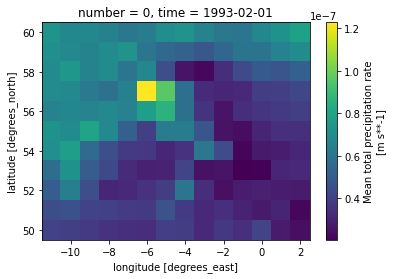

In [36]:
pr_1993_ds['tprate'].sel(number=0,time='1993-02').plot()

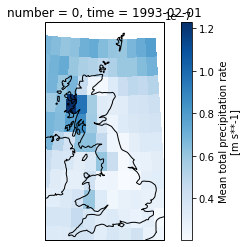

In [37]:
## Use cartopy for nicer maps
ax = plt.axes(projection= ccrs.OSGB())
pr_1993_ds['tprate'].sel(number=0,time='1993-02').plot(transform=ccrs.PlateCarree(),cmap=plt.cm.Blues, ax=ax)  #,cmap=plt.cm.Blues,

# ax.set_extent(extent)
ax.coastlines(resolution='50m')
plt.draw()